## Short Rate vs Annualized

# CIR Model to simulate changes in Interest Rates and Liability Hedging

The Cox Ingersoll Ross model is used to model the dynamics of the interest rates, and is an extension of the popular Vasicek Model to prevent 
negative interest rates:

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt {r_{t}}}\,dw_{t} $$

In [18]:
import numpy as np
import pandas as pd 
import Risk_Kit as erk
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def inst_to_ann(r):
    """
    Convert short rate to an annulized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert annulized to a short rate
    """
    return np.log1p(r)


In [20]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year)+1# becasue n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ###
     
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t) * shock[step]
        rates[step] = abs(r_t + d_r_t)
        #generate prices at time t as well...
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

    

<AxesSubplot:>

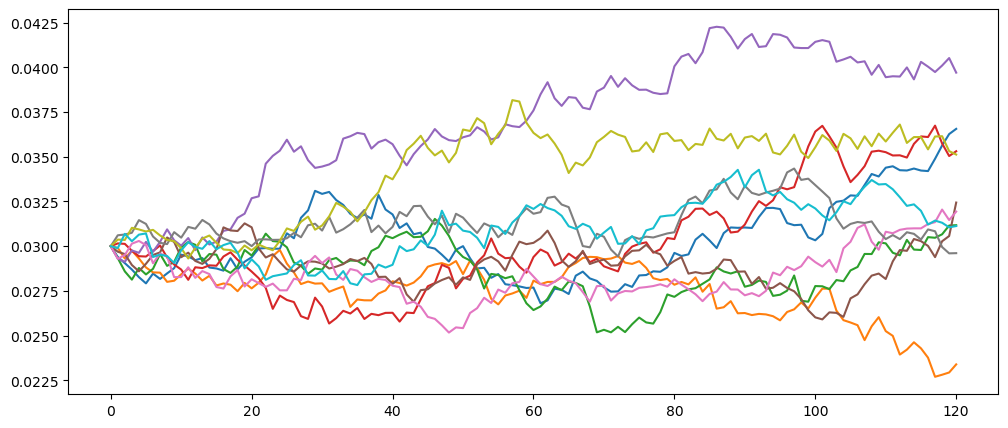

In [21]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend = False)

In [22]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))

import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir,
                               r_0 = (0, .15, .01),
                               a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma = (0, .1, .01),
                               n_scenarios = (1, 100))

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [10]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year)+1# becasue n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ###
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
              
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t) * shock[step]
        rates[step] = abs(r_t + d_r_t)
        #generate prices at time t as well...
        prices[step] = price(n_years-step*dt, rates[step])
    
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ###for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    
    return rates, prices 

In [11]:
a_0 = 0.75
rates,bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zcbond_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds=n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

<AxesSubplot:>

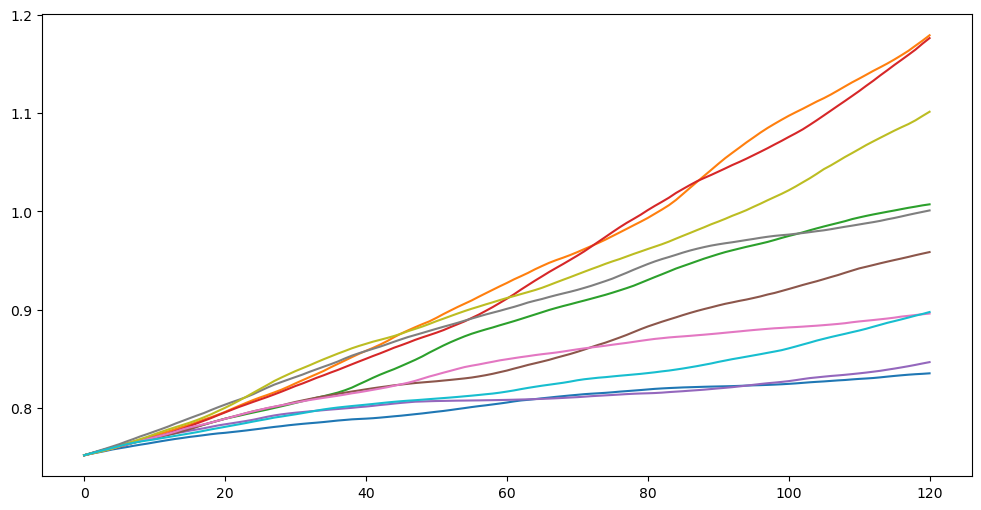

In [12]:
av_cash.plot(legend=False, figsize=(12,6))

<AxesSubplot:>

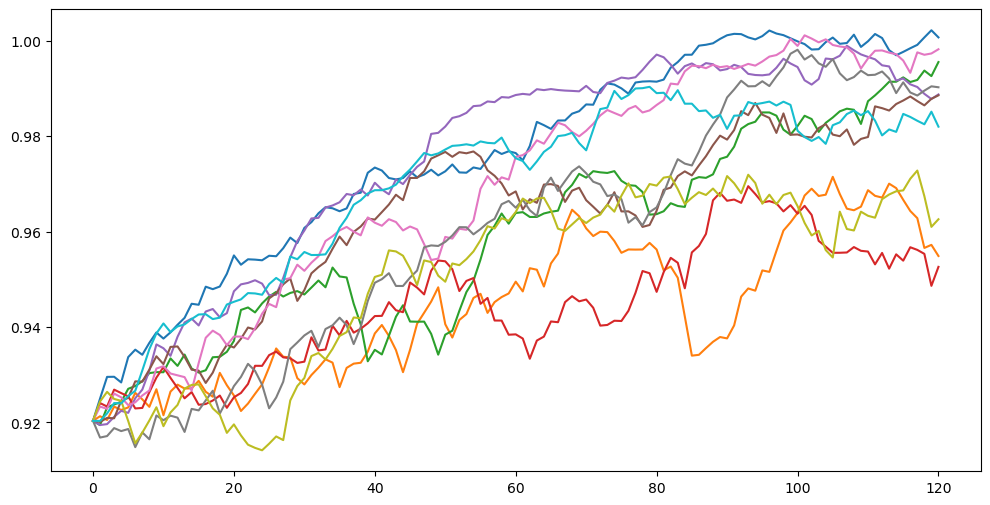

In [13]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

<AxesSubplot:title={'center':'Returns pf Funding Ratio with Cash (10 scenarios)'}>

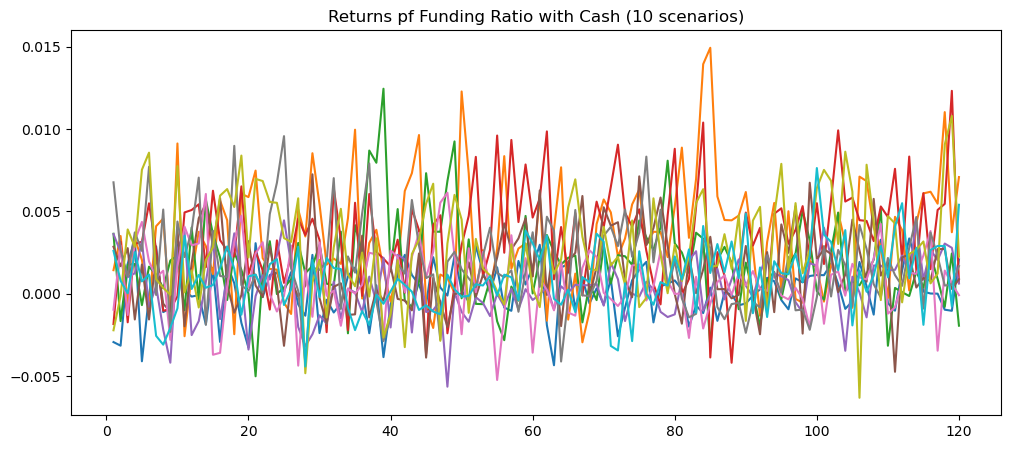

In [14]:
(av_cash/liabilities).pct_change().plot(title="Returns pf Funding Ratio with Cash (10 scenarios)", legend=False, figsize=(12,5))

<AxesSubplot:title={'center':'Returns pf Funding Ratio with Cash (10 scenarios)'}>

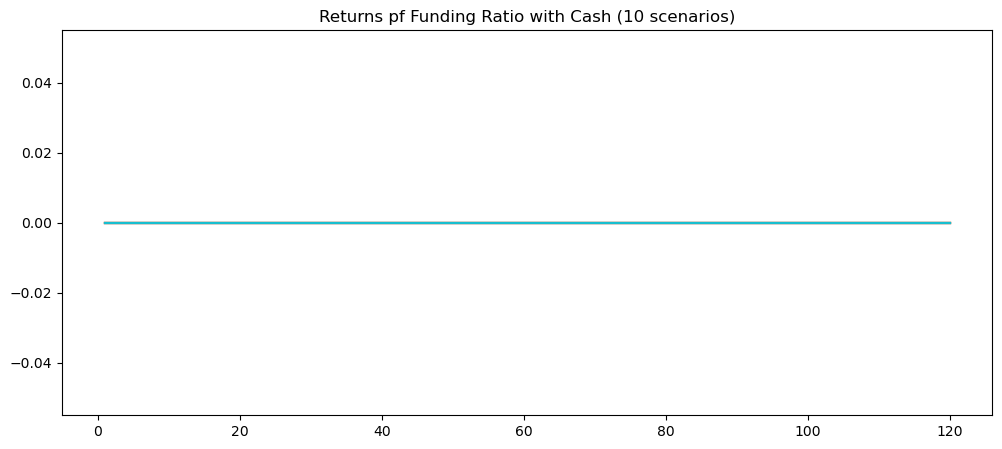

In [15]:
(av_zc_bonds/liabilities).pct_change().plot(title="Returns pf Funding Ratio with Cash (10 scenarios)", legend=False, figsize=(12,5))

In [16]:
a_0 = 0.5
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()


<AxesSubplot:>

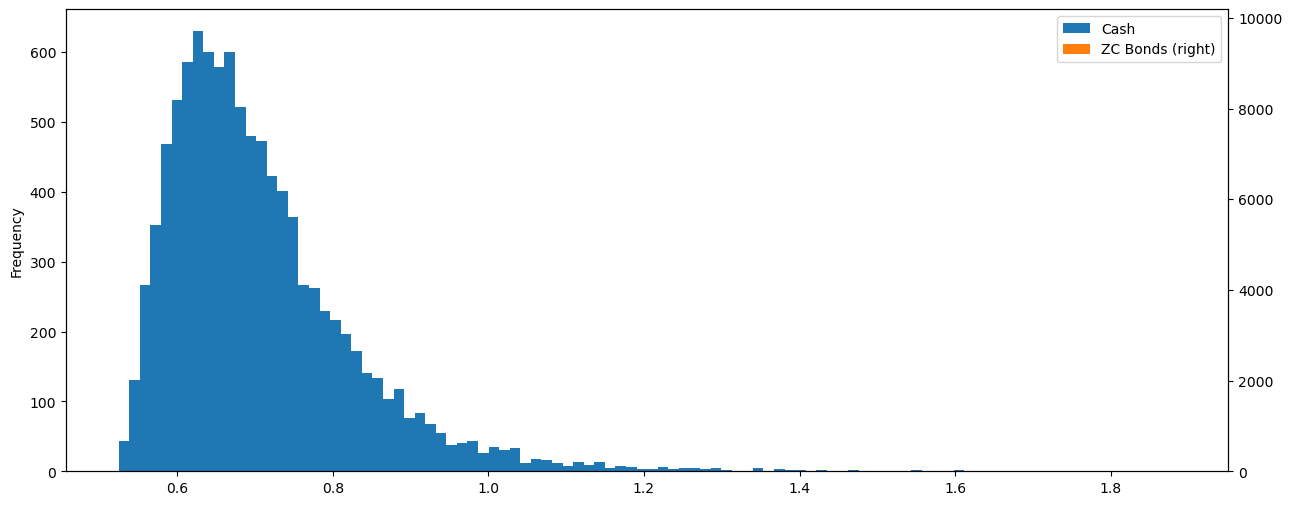

In [17]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(15,6) ,bins=100,legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label="ZC Bonds", bins=100,legend=True, secondary_y=True)